In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/depth_estimation_2/nyu2_train.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/depth_estimation_2/output.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2DTranspose
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
physical_device = tf.config.list_physical_devices("GPU")
# tf.config.gpu.set_per_process_memory_fraction(0.5)
try:
    tf.config.experimental.set_memory_growth(
        physical_device[0], True
    )
except Exception as e:
    print(e)

In [ ]:

# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3,(1,1),strides=(1,1),padding='valid',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters =F1, kernel_size =(1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters =F2, kernel_size =(f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters =F3, kernel_size =(1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters =F3, kernel_size =(1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 1)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 1)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
   
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (240, 320, 3))
print(model.output_shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input

In [ ]:
class LSU(tf.keras.layers.Layer):
    def __init__(self, kernal, unit = 32):
        super(LSU, self).__init__()
        self.unit = unit
        self.kernal = kernal
    
    def build(self, kernal):
        self.kernal_d1 = self.add_weight(shape=(self.kernal[-1], self.unit), dtype = tf.float32, name = 'alpha')
        self.kernal_s1 = self.add_weight(shape=(self.kernal[-1], self.unit), dtype = tf.float32, name = 'gamma')
    
    def call(self, input_tensor):
        layer = (input_tensor[0] * self.kernal_d1) + (input_tensor[1] * self.kernal_s1)
        return layer
      
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'unit': self.unit,
            'kernal': self.kernal})
        #     'units': self.units,
        #     'd_model': self.d_model,
        #     'num_heads': self.num_heads,
        #     'dropout': self.dropout,
        # })
        return config

In [ ]:
x1_depth=tf.keras.layers.Conv2DTranspose(512,(2,2),name='conv1_d',activation='relu', strides = 2)(model.output)

x1_semantic=tf.keras.layers.Conv2DTranspose(512,(2,2),name='conv1_s',activation='relu', strides = 2)(model.output)

x2_depth=tf.keras.layers.Conv2DTranspose(128,(2,2), strides = 2, name='conv2_d',activation='relu')(x1_semantic)

x2_semantic=tf.keras.layers.Conv2DTranspose(128,(2,2), strides = 2, name='conv2_s',activation='relu')(x1_semantic)

layer_1 = LSU(kernal = (1,1), unit = 512)
lsu_1 = layer_1([x1_depth, x1_semantic])
lsu_1 = tf.keras.layers.Conv2DTranspose(x2_depth.shape[-1], (2,2), strides = 2, name = 'lsu_1_t', activation = 'relu')(lsu_1)

x3_depth_input = tf.keras.layers.Add(name = 'x3_d_input')([x2_depth, lsu_1])
x3_semantic_input = tf.keras.layers.Add(name = 'x3_s_input')([x2_semantic, lsu_1])

x3_depth=tf.keras.layers.Conv2DTranspose(64,(2,2),strides = 2,name='conv3_d',activation='relu')(x3_depth_input)

x3_semantic=tf.keras.layers.Conv2DTranspose(64,(2,2),strides = 2,name='conv3_s',activation='relu')(x3_semantic_input)

layer_2 = LSU(kernal = (1,1), unit = 128)
lsu_2 = layer_2([x2_depth, x2_semantic])
lsu_2 = tf.keras.layers.Conv2DTranspose(x3_depth.shape[-1], (2,2), strides = 2, name = 'lsu_2_t', activation = 'relu')(lsu_2)

x4_depth_input = tf.keras.layers.Add(name = 'x4_d_input')([x3_depth, lsu_2])
x4_semantic_input = tf.keras.layers.Add(name = 'x4_s_input')([x3_semantic, lsu_2])

x4_depth = tf.keras.layers.Conv2DTranspose(1,(2,2),strides = 2, name="conv4_d",activation='relu')(x4_depth_input)

x4_semantic = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = 2, name="conv4_s",activation='relu')(x4_semantic_input)



'''
  Apply semi dense up skip connection between f_in, f1, f2, f3 layer
  f_out=h(f_in)+sumation_of_(h(f(i))) where i belong to (1,n)
'''
#add_shape  of f4 output
x4_semantic_shape_x_y = (240,320)
x4_semantic_filters=x4_semantic.shape[-1]

# BASE INPUT LAYER UPSAMPLING
bilinear_upsampling_in = tf.keras.layers.experimental.preprocessing.Resizing(x4_semantic_shape_x_y[0], x4_semantic_shape_x_y[1], interpolation='bilinear')(model.output)
x_semantic_out_in=tf.keras.layers.Conv2D(x4_semantic_filters,(1,1),name='resize_filter_conv_in_s',activation='relu')(bilinear_upsampling_in)

# FIRST LAYER BILINEAR UPsAMPLING
bilinear_upsampling_1 = tf.keras.layers.experimental.preprocessing.Resizing(x4_semantic_shape_x_y[0], x4_semantic_shape_x_y[1], interpolation='bilinear')(x1_semantic)
x_semantic_out1 = tf.keras.layers.Conv2D(x4_semantic_filters,(1,1),name='resize_filter_conv1_s',activation='relu')(bilinear_upsampling_1)

#SECOND LAYER BILINEAR UPSAMPLING
bilinear_upsampling_2 = tf.keras.layers.experimental.preprocessing.Resizing(x4_semantic_shape_x_y[0], x4_semantic_shape_x_y[1], interpolation='bilinear')(x2_semantic)
x_semantic_out2 = tf.keras.layers.Conv2D(x4_semantic_filters,(1,1),name='resize_filter_conv2_s',activation='relu')(bilinear_upsampling_2)

# 3rd LAYER UPSAMPLING
bilinear_upsampling_3 = tf.keras.layers.experimental.preprocessing.Resizing(x4_semantic_shape_x_y[0], x4_semantic_shape_x_y[1], interpolation='bilinear')(x3_semantic)
x_semantic_out3 = tf.keras.layers.Conv2D(x4_semantic_filters,(1,1),name='resize_filter_conv3_s',activation='relu')(bilinear_upsampling_3)
# bilinear_upsampling_3 = tf.keras.layers.experimental.preprocessing.Resizing(f4.shape[1], f4.shape[2], interpolation='bilinear')(f3)
# f_out3 = tf.keras.layers.Conv2D(f4_filters,(1,1),name='resize_filter_conv3')(bilinear_upsampling_3)

#F_out LAYER UPSAMPLING
bilinear_upsampling_4 = tf.keras.layers.experimental.preprocessing.Resizing(x4_semantic_shape_x_y[0], x4_semantic_shape_x_y[1], interpolation='bilinear')(x4_semantic)
x_semantic_out4 = tf.keras.layers.Conv2D(x4_semantic_filters,(1,1),name='resize_filter_conv4_s', activation='relu')(bilinear_upsampling_4)


''' Applying formulae for semi dense up skip connection '''
x_semantic_out_final1=tf.keras.layers.Add(name = 'final_semantic_layer_1')([x_semantic_out_in,x_semantic_out1,x_semantic_out2,x_semantic_out3,x_semantic_out4])
x_semantic_out_final = tf.keras.layers.Activation('sigmoid', name = 'semantic_final_layer')(x_semantic_out_final1)


#####################################################################################################################################
#####################################################################################################################################
#add_shape  of f4 output
x4_depth_shape_x_y = (240,320)
x4_depth_filters=x4_depth.shape[-1]

# BASE INPUT LAYER UPSAMPLING
bilinear_upsampling_in_d = tf.keras.layers.experimental.preprocessing.Resizing(x4_depth_shape_x_y[0], x4_depth_shape_x_y[1], interpolation='bilinear')(model.output)
x_depth_out_in=tf.keras.layers.Conv2D(x4_depth_filters,(1,1),name='resize_filter_conv_in_d',activation='relu')(bilinear_upsampling_in_d)

# FIRST LAYER BILINEAR UPsAMPLING
bilinear_upsampling_1_d = tf.keras.layers.experimental.preprocessing.Resizing(x4_depth_shape_x_y[0], x4_depth_shape_x_y[1], interpolation='bilinear')(x1_depth)
x_depth_out1 = tf.keras.layers.Conv2D(x4_depth_filters,(1,1),name='resize_filter_conv1_d',activation='relu')(bilinear_upsampling_1_d)

#SECOND LAYER BILINEAR UPSAMPLING
bilinear_upsampling_2_d = tf.keras.layers.experimental.preprocessing.Resizing(x4_depth_shape_x_y[0], x4_depth_shape_x_y[1], interpolation='bilinear')(x2_depth)
x_depth_out2 = tf.keras.layers.Conv2D(x4_depth_filters,(1,1),name='resize_filter_conv2_d',activation='relu')(bilinear_upsampling_2_d)

# 3rd LAYER UPSAMPLING
bilinear_upsampling_3_d = tf.keras.layers.experimental.preprocessing.Resizing(x4_depth_shape_x_y[0], x4_depth_shape_x_y[1], interpolation='bilinear')(x3_depth)
x_depth_out3 = tf.keras.layers.Conv2D(x4_depth_filters,(1,1),name='resize_filter_conv3_d',activation='relu')(bilinear_upsampling_3_d)
# bilinear_upsampling_3 = tf.keras.layers.experimental.preprocessing.Resizing(f4.shape[1], f4.shape[2], interpolation='bilinear')(f3)
# f_out3 = tf.keras.layers.Conv2D(f4_filters,(1,1),name='resize_filter_conv3')(bilinear_upsampling_3)

#F_out LAYER UPSAMPLING
bilinear_upsampling_4_d = tf.keras.layers.experimental.preprocessing.Resizing(x4_depth_shape_x_y[0], x4_depth_shape_x_y[1], interpolation='bilinear')(x4_depth)
x_depth_out4 = tf.keras.layers.Conv2D(x4_depth_filters,(1,1),name='resize_filter_conv4_d', activation='relu')(bilinear_upsampling_4_d)


''' Applying formulae for semi dense up skip connection '''
x_depth_out_final=tf.keras.layers.Add(name = 'depth_final_layer')([x_depth_out_in,x_depth_out1,x_depth_out2,x_depth_out3,x_depth_out4])

output = [x_semantic_out_final, x_depth_out_final]
model_final = tf.keras.models.Model(inputs = model.input, outputs = output)



In [ ]:
model_final.summary()

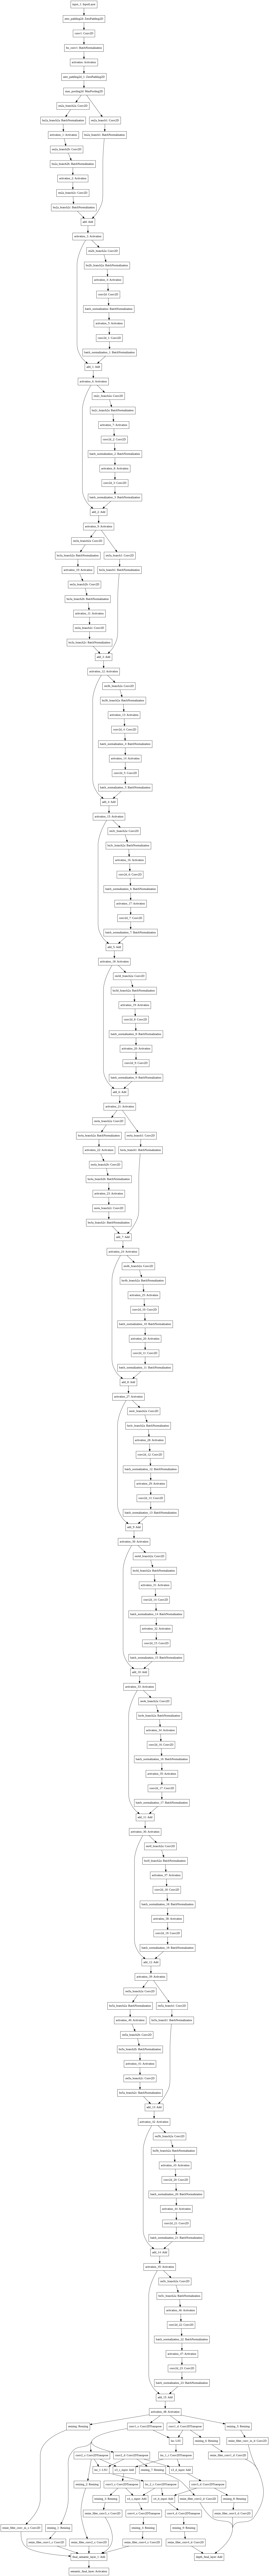

In [ ]:
plot_model(model_final)

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import os
import json


class DataGenerator(Sequence):
    def __init__(self, x_data, y_depth, y_semantic,
                 batch_size=32, dim=(320,240),
                 shuffle=True):
        self.x_data = x_data
        self.y_depth = y_depth
        self.y_semantic = y_semantic
        self.batch_size = batch_size
        self.dim = dim


    def __len__(self):
        return int(np.floor(len(self.x_data) / self.batch_size))


    def __getitem__(self, index):
        start_index = index * self.batch_size
        x_train = []
        y_train_depth = []
        y_train_semantic = []
        i = start_index - 1
        while len(x_train) < self.batch_size:
            try:
                
                img = cv2.imread(self.x_data[i % len(self.x_data)])
                img = cv2.resize(img,(320,240))
                # img = np.array(img, dtype = np.float32)
                img = img / 255.0

                y_depth = cv2.imread(self.y_depth[i%len(self.y_depth)])
                y_depth = cv2.cvtColor(y_depth,cv2.COLOR_BGR2GRAY)
                y_depth = cv2.resize(y_depth, (320,240))
                # y_depth = np.array(y_depth, dtype = np.float32)
                y_depth = y_depth / 255.0

                y_semantic = cv2.imread(self.y_semantic[i % len(self.y_semantic)])
                y_semantic = cv2.resize(y_semantic,(320,240))
                # y_semantic = np.array(y_semantic, dtype = np.float32)
                y_semantic = y_semantic / 255.0
                
                x_train.append(img)
                y_train_depth.append(y_depth)
                y_train_semantic.append(y_semantic)
                # x_train = np.array(x_train, dtype = np.float32)
                # y_train_depth = np.array(y_train_depth, dtype = np.float32)
                # y_train_semantic = np.array(y_train_semantic, dtype = np.float32)


                i += 1

            except Exception as err:
                print(err)
                continue
        y_train = [np.array(y_train_semantic), np.array(y_train_depth)]

        return np.array(x_train), y_train

In [ ]:
import os
import cv2
import numpy as np
path_images = '/content/nyu2_train'
path_segmented = '/content/output'
semanted_paths = []
img_paths = []
depth_paths = []
for i in os.listdir(path_segmented):
    for j in os.listdir(path_segmented + '/' + i):
        semanted = path_segmented + '/' + i + '/' + j
        img = path_images + '/' + i + '/' + j
        depth = path_images + '/' + i + '/' + j[:-4] + '.png'
        semanted_paths.append(semanted)
        img_paths.append(img)
        depth_paths.append(depth)

semanted_paths = np.array(semanted_paths)
img_paths = np.array(img_paths)
depth_paths = np.array(depth_paths)

In [ ]:
print(len(img_paths))

7332


In [ ]:
train_data = DataGenerator(img_paths, depth_paths, semanted_paths, batch_size=2, dim=(320,240))

In [ ]:
q = train_data.__getitem__(0)

In [ ]:

type(q[0])

numpy.ndarray

In [ ]:
def depth_aware_loss(y_true, y_pred):
  i = y_true
  y_true = tf.convert_to_tensor(y_true, dtype = tf.float32) * 255.0
  y_pred = tf.convert_to_tensor(y_pred, dtype = tf.float32) * 255.0
  y_true = tf.clip_by_value(y_true, 1.0, 255.0)
  y_pred = tf.clip_by_value(y_pred, 1.0, 255.0)
  lambda_d = 1 - (tf.math.minimum(tf.math.log(y_true), tf.math.log(y_pred)) / tf.math.maximum(tf.math.log(y_true), tf.math.log(y_pred)))

  loss = tf.reduce_mean((i + lambda_d) * tf.math.abs(y_true - y_pred))
  return loss

In [ ]:
def depth_gradient_loss(y_true, y_pred):

    y_true = tf.image.convert_image_dtype(y_true, dtype=tf.float32)
    y_true = tf.expand_dims(y_true, axis = 3)
    y_pred = tf.image.convert_image_dtype(y_pred, dtype = tf.float32)
    y_pred = tf.expand_dims(y_pred, axis = 3)
    #y_true edges

    sobel_true = tf.image.sobel_edges(y_true)
    sobel_true_h = sobel_true[0, :, :, :, 0]
    sobel_true_w = sobel_true[0, :, :, :, 1]
    #y_pred edges
    sobel_pred = tf.image.sobel_edges(y_pred)
    sobel_pred_h = sobel_pred[0, :, :, :, 0]
    sobel_pred_w = sobel_pred[0, :, :, :, 1]
    #loss
    # y_true = tf.squeeze(y_true, axis = 0)
    # t_pred = tf.squeeze(y_pred, axis = 0)
    loss_depth = tf.reduce_mean(tf.math.abs(sobel_pred_h - sobel_true_h) + tf.math.abs(sobel_pred_w - sobel_true_w))
#     N = y_true.shape[1]
#     loss_depth = loss_depth/(N * N)
    return loss_depth

In [ ]:
def combined_depth_loss(y_true, y_pred):
  loss1 = depth_aware_loss(y_true, y_pred)
  loss2 = depth_gradient_loss(y_true, y_pred)
  loss_combined = loss1 + loss2
  return loss_combined

In [ ]:
def loss_focal(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype = tf.float32)
    y_pred = tf.clip_by_value(y_pred, 0.0039215686274, 1.0)
    y_true = tf.clip_by_value(y_true, 0.0039215686274, 1.0)
    y_pred = tf.nn.softmax(y_pred)
    alpha = tf.ones_like(y_true, dtype = tf.float32) * 0.25
    gamma = 2
    loss = tf.reduce_mean(alpha * tf.math.pow((1 - y_pred), 2) * (-tf.reduce_sum(y_true * tf.math.log(y_pred))))
    return loss

In [ ]:
def semantic_gradient_loss(y_true, y_pred):
    y_true = tf.image.convert_image_dtype(y_true, dtype=tf.float32)
    # y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.image.convert_image_dtype(y_pred, dtype = tf.float32)
    # y_pred = tf.expand_dims(y_pred, axis = -1)

    sobel_true = tf.image.sobel_edges(y_true)
    sobel_true_h = sobel_true[0, :, :, :, 0]
    sobel_true_w = sobel_true[0, :, :, :, 1]
    #y_pred edges
    sobel_pred = tf.image.sobel_edges(y_pred)
    sobel_pred_h = sobel_pred[0, :, :, :, 0]
    sobel_pred_w = sobel_pred[0, :, :, :, 1]
    #loss

    loss_semantic = tf.reduce_mean(tf.math.abs(sobel_pred_h - sobel_true_h) + tf.math.abs(sobel_pred_w - sobel_true_w))
    return loss_semantic

In [ ]:
def combined_semantic_loss(y_true, y_pred):
  y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
  y_pred = tf.convert_to_tensor(y_pred, dtype = tf.float32)
  loss1 = loss_focal(y_true, y_pred)
  loss2 = semantic_gradient_loss(y_true, y_pred)
  loss_combined = loss1 + loss2
  return loss_combined

In [ ]:
loss = {'depth_final_layer' : combined_depth_loss, 'semantic_final_layer' : combined_semantic_loss}

In [ ]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    TensorBoard
)

In [ ]:
callbacks_semantic = [tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/combined_model/checkpoints/train_{epoch}.tf", verbose = 1,
                                                save_weights_only=True),
             TensorBoard("/content/drive/MyDrive/combined_model/combined_logs")]
callbacks = [callbacks_semantic]

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.0001)

In [ ]:
model_final.compile(optimizer=optimizer,loss=loss)

In [ ]:
model_final.load_weights("/content/drive/MyDrive/combined_model/checkpoints/train_8.tf")

In [ ]:
model_final.fit(train_data, epochs=50, verbose=1, callbacks=callbacks)###30 completed

Epoch 1/50
3666/3666 [==============================] - 1645s 437ms/step - loss: 24594.8045 - semantic_final_layer_loss: 24500.9637 - depth_final_layer_loss: 93.8457

Epoch 00001: saving model to /content/drive/MyDrive/combined_model/checkpoints/train_1.tf
Epoch 2/50
3666/3666 [==============================] - 1605s 438ms/step - loss: 24659.5280 - semantic_final_layer_loss: 24565.4462 - depth_final_layer_loss: 94.0567

Epoch 00002: saving model to /content/drive/MyDrive/combined_model/checkpoints/train_2.tf
Epoch 3/50
3666/3666 [==============================] - 1605s 438ms/step - loss: 24632.3469 - semantic_final_layer_loss: 24538.6129 - depth_final_layer_loss: 93.7355

Epoch 00003: saving model to /content/drive/MyDrive/combined_model/checkpoints/train_3.tf
Epoch 4/50
3666/3666 [==============================] - 1608s 439ms/step - loss: 24551.3627 - semantic_final_layer_loss: 24458.1639 - depth_final_layer_loss: 93.1898

Epoch 00004: saving model to /content/drive/MyDrive/combined_m